In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import umap
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

**Читаем данные**

In [2]:
# в папке первые 5 файлов из тренировочного набора данных
data_dir = Path('./lab1_data/')

In [3]:
%%time
full_df = pd.concat(pd.read_parquet(parquet_file) for parquet_file in data_dir.glob('*.parquet'))

CPU times: user 7 s, sys: 15.6 s, total: 22.6 s
Wall time: 17.6 s


In [4]:
full_df.shape

(27045150, 20)

In [5]:
# уникальных значений заявок - 110К, что бы это ни значило
full_df.app_id.nunique()

110700

In [6]:
full_df.head(10)

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
417917,92990,0.387677,1,2,8,3,1,1,6,1,2,1,2,2,2,13,359,44,-1,1
417918,92990,0.387677,1,2,8,7,1,1,1,1,2,1,49,2,2,16,359,44,4,2
417919,92990,0.339712,1,1,8,1,1,1,1,1,1,1,49,1,2,21,359,44,5,3
417920,92990,0.359050,1,2,8,7,1,1,1,1,2,1,49,2,7,9,358,44,12,4
417921,92990,0.346552,1,1,5,2,1,1,2,1,5,1,2,4,7,14,358,44,5,5
417922,92990,0.348840,1,1,8,1,1,1,1,1,7,1,2,5,7,23,358,44,9,6
417923,92990,0.296347,1,1,8,1,1,1,1,1,1,1,49,1,5,12,356,21,37,7
417924,92990,0.253122,1,1,8,1,1,1,1,1,4,1,49,3,5,13,356,21,1,8
417925,92990,0.348838,1,2,8,3,1,1,6,1,2,1,2,2,4,1,355,21,11,9
417926,92990,0.294135,1,1,8,1,1,1,1,1,1,1,49,1,4,13,355,21,12,10


***Составить профили временной активности для каждого пользователя***

**Суточный (по часам)**

In [7]:
hour_df = pd.pivot_table(full_df, values='transaction_number', index='app_id', columns='hour',
               aggfunc='count', fill_value=0)

In [8]:
hour_df.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
app_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,3,5,9,...,17,12,23,10,16,19,7,1,0,1
1,4,0,0,0,0,0,0,1,39,15,...,33,17,20,23,14,14,31,42,10,2
2,8,0,4,0,1,0,1,2,3,6,...,15,15,8,12,24,18,24,22,17,9
3,1,0,6,0,0,0,0,3,4,2,...,7,1,3,8,5,3,4,2,1,2
4,0,0,0,0,0,1,13,17,1,0,...,5,7,6,13,11,10,3,3,3,0


In [9]:
# нормализуем данные по дневной активности
hour_df = hour_df.div(hour_df.max(axis=1), axis=0)
hour_df.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
app_id,,,,,,,,,,,,,,,,,,,,,
0,0.040000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.120000,0.200000,0.360000,...,0.680000,0.480000,0.920000,0.400000,0.640000,0.760000,0.280000,0.040000,0.000000,0.040000
1,0.095238,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.023810,0.928571,0.357143,...,0.785714,0.404762,0.476190,0.547619,0.333333,0.333333,0.738095,1.000000,0.238095,0.047619
2,0.333333,0.0,0.166667,0.0,0.041667,0.000000,0.041667,0.083333,0.125000,0.250000,...,0.625000,0.625000,0.333333,0.500000,1.000000,0.750000,1.000000,0.916667,0.708333,0.375000
3,0.125000,0.0,0.750000,0.0,0.000000,0.000000,0.000000,0.375000,0.500000,0.250000,...,0.875000,0.125000,0.375000,1.000000,0.625000,0.375000,0.500000,0.250000,0.125000,0.250000
4,0.000000,0.0,0.000000,0.0,0.000000,0.058824,0.764706,1.000000,0.058824,0.000000,...,0.294118,0.411765,0.352941,0.764706,0.647059,0.588235,0.176471,0.176471,0.176471,0.000000


Определим вспомогательные функции для выбора количества кластеров и для визуализации

In [10]:
def count_clusters(df):
    res = pd.DataFrame(['Коэффициент силуэта', 'Индекс Калинского-Харабаза', 'Индекс Дэвиса-Болдина'], columns = ['Kmeans, n_classes'])
    for n in range(2, 11):
        cl = KMeans(n_clusters=n, random_state=20)
        clusters = cl.fit(df).predict(df)
        res[str(n)] = [ silhouette_score(df, clusters), calinski_harabasz_score(df, clusters), davies_bouldin_score(df, clusters)]
    return res

In [13]:
def visual(df, n_value, n_clusters=4):
        cl = KMeans(n_clusters=n_clusters, random_state=20)
        clusters = cl.fit(df).predict(df)
        print(f'Распределение по кластерам: {np.unique(clusters, return_counts=True)[1]}')
        
        # Уменьшаем размерность
        reducer = umap.UMAP(random_state=42, n_components=2)
        embedding = reducer.fit_transform(df)
        
        plt.figure(figsize=(16,10))
        sns.scatterplot(
            x=reducer.embedding_[:, 0], y=reducer.embedding_[:, 1],
            hue=clusters,
            palette="deep",
            legend="full",
        )
        _ = plt.legend()
        
        plt.figure(figsize=(16,10))
        for i in range(n_clusters):
            plt.plot([j for j in range(1, n_value+1)], cl.cluster_centers_[i], label = f"{i}")
            _ = plt.legend()

Качество кластеризации будем сравнивать по следующим метрикам:

**Коэффициент силуэта**

Лучшее значение равно 1, а худшее значение равно -1. Значения около 0 указывают на перекрывающиеся кластеры. Отрицательные значения обычно указывают на то, что образец был отнесен к неправильному кластеру, так как другой кластер более похож.

**Индекс  Калинского-Харабаза**

Более высокое значение индекса КХ означает, что кластеры плотные и хорошо разделены, хотя нет «приемлемого» порогового значения. Нам нужно выбрать то решение, которое дает пик или хотя бы крутой изгиб на линейном графике индексов КХ. С другой стороны, если линия гладкая (горизонтальная, восходящая или нисходящая), то нет причин предпочитать одно решение другим.

**Индекс Дэвиса-Болдина**

Минимальная оценка равна нулю, а более низкие значения указывают на лучшую кластеризацию.

In [14]:
# рассчитаем метрики кластеризации по подвыборке из 10% данных
count_clusters(hour_df.sample(frac=0.1, random_state=43))

,"Kmeans, n_classes",2,3,4,5,6,7,8,9,10
0,Коэффициент силуэта,0.155353,0.119721,0.111540,0.106828,0.105675,0.098715,0.098144,0.096035,0.090822
1,Индекс Калинского-Харабаза,2234.105879,1753.209122,1526.124121,1344.837567,1205.354397,1097.749726,1017.069954,948.744205,884.956785
2,Индекс Дэвиса-Болдина,2.182574,2.186874,2.168768,2.228721,2.219508,2.202441,2.234359,2.258529,2.275084


Распределение по кластерам: [28001 30623 24205 27871]


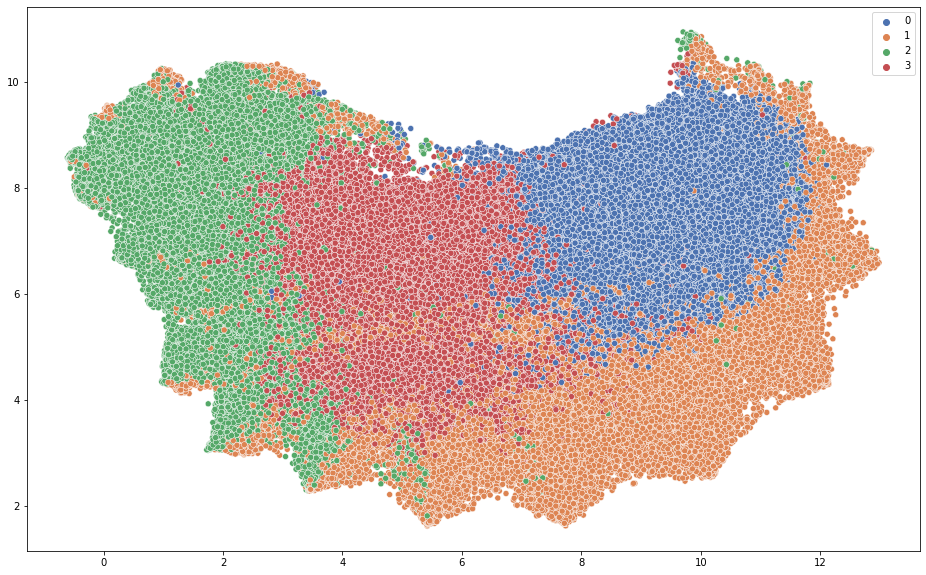

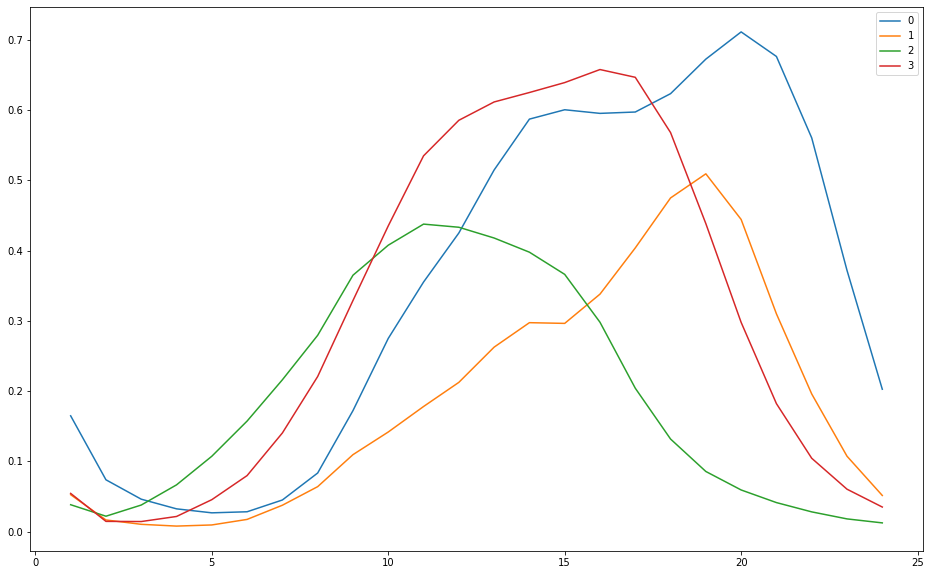

In [15]:
# выбираем количество кластеров 4, так как здесь самое минимальное значение индекса Дэвиса-Болдина
# остальные метрики отличаются не значимо 
visual(hour_df, 24, 4)

Интерпретация.

Кластер 0 (синяя линия) - "совы", количество покупок возрастает к вечеру

Кластер 1 (оранжевая линия) - похоже на предыдущую группу, но делают еньше покупок чем синие

Кластер 2 (зеленая линия) - "жаворонки", большинство покупок утром и днём

Кластер 3 (красная линия) - промежуточное звено, в основном делают покупки днём

**Недельный (по дням)**

In [16]:
day_of_week_df = pd.pivot_table(full_df, values='transaction_number', index='app_id', columns='day_of_week',
               aggfunc='count', fill_value=0)

In [17]:
# нормализуем данные по недельной активности
day_of_week_df = day_of_week_df.div(day_of_week_df.max(axis=1), axis=0)
day_of_week_df.head()

day_of_week,1,2,3,4,5,6,7
app_id,,,,,,,
0,0.580645,0.903226,0.645161,1.000000,0.935484,1.000000,0.774194
1,0.532468,0.597403,1.000000,0.844156,0.571429,0.623377,0.454545
2,1.000000,0.500000,0.568182,0.795455,0.772727,0.795455,0.772727
3,1.000000,0.750000,0.312500,0.687500,0.500000,0.500000,0.437500
4,1.000000,0.375000,0.625000,0.750000,0.750000,0.833333,0.541667


In [18]:
# рассчитаем метрики кластеризации по подвыборке из 10% данных
count_clusters(day_of_week_df.sample(frac=0.1, random_state=43))

,"Kmeans, n_classes",2,3,4,5,6,7,8,9,10
0,Коэффициент силуэта,0.254594,0.224023,0.217080,0.149473,0.154418,0.143908,0.147736,0.151417,0.154546
1,Индекс Калинского-Харабаза,3170.227906,2555.052565,2162.099806,1944.493074,1760.346444,1645.470584,1538.872686,1463.763535,1397.254380
2,Индекс Дэвиса-Болдина,1.807945,1.769491,1.840657,1.849111,1.841878,1.810009,1.712412,1.686547,1.616106


Распределение по кластерам: [21638 58527 30535]


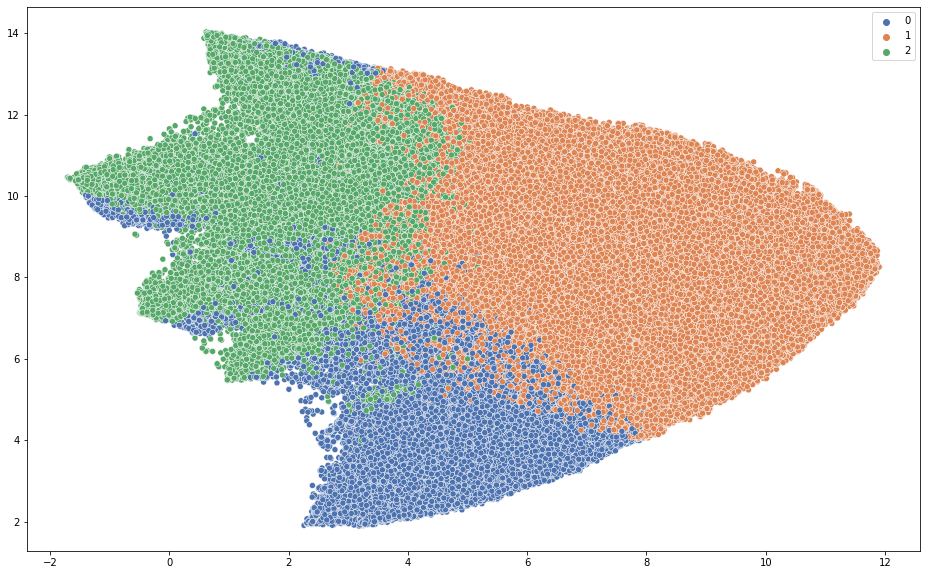

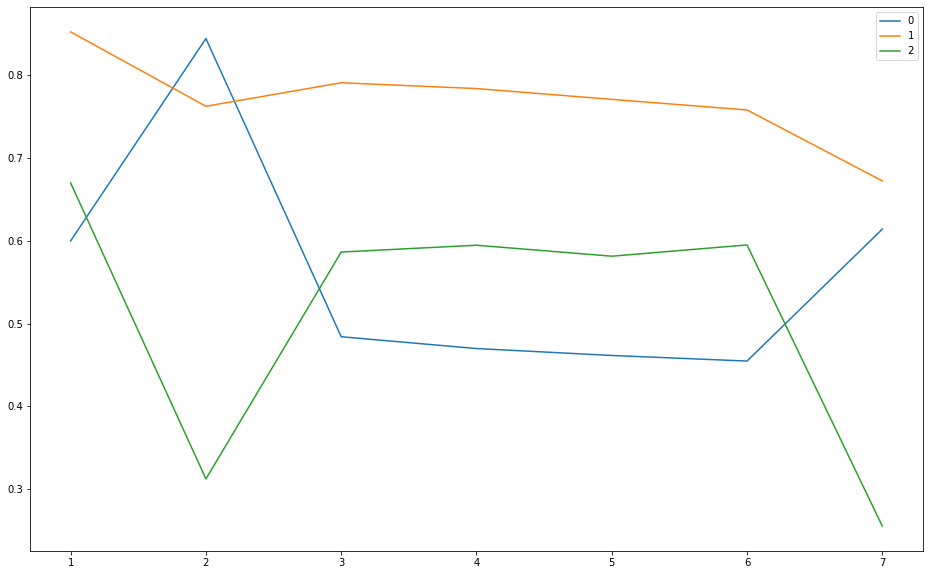

In [19]:
# оптимальное значение по совокупности метрик - 3 кластера
visual(day_of_week_df, 7, 3)

Интерпретация.

Здесь не понятно, что именно считается первым днём недели - воскресенье или понедельник. Допустим это воскренье.

Кластер 0 (синяя линия) - большинство покупок в понедельник. Возможно отдыхают в выходные или любят начинать новые дела с началом новой недели. Также рост числа покупок в этом кластере идёт в субботу.

Кластер 1 (оранжевая линия) - покупают стабильно много, немного падает количество в понедельник и субботу.

Кластер 2 (зеленая линия) - "воскресные" покупатели, в понедельник и субботу отдыхают от покупок.

**Годовой (по месяцам)**

In [20]:
# определение месяца оказалось сложной задачей, поэтому пусть будет пока так
full_df['day_of_year'] = (full_df['weekofyear'] - 1)*7 + full_df['day_of_week']
full_df['month'] = (full_df['day_of_year'] // 31 + 1)

In [21]:
months_df = pd.pivot_table(full_df, values='transaction_number', index='app_id', columns='month',
               aggfunc='count', fill_value=0)

In [22]:
# нормализуем данные по месячной активности
months_df = months_df.div(months_df.max(axis=1), axis=0)
months_df.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
app_id,,,,,,,,,,,,
0,0.466667,1.000000,0.533333,0.433333,0.666667,0.566667,0.400000,0.333333,0.600000,0.266667,0.500000,0.266667
1,0.163636,0.345455,0.272727,0.836364,1.000000,0.490909,0.781818,0.472727,0.436364,0.654545,0.581818,0.436364
2,0.588235,0.500000,0.352941,0.500000,0.735294,0.617647,1.000000,0.500000,0.411765,0.911765,0.441176,0.176471
3,0.333333,1.000000,0.000000,0.000000,0.866667,0.800000,0.000000,0.000000,0.133333,0.800000,0.400000,0.133333
4,0.444444,0.555556,0.555556,0.333333,1.000000,0.500000,0.500000,0.722222,0.555556,0.555556,0.500000,0.277778


In [23]:
# рассчитаем метрики кластеризации по подвыборке из 10% данных
count_clusters(months_df.sample(frac=0.1, random_state=43))

,"Kmeans, n_classes",2,3,4,5,6,7,8,9,10
0,Коэффициент силуэта,0.184577,0.166705,0.158101,0.110532,0.111482,0.098146,0.097203,0.097381,0.100745
1,Индекс Калинского-Харабаза,2728.518207,1992.727665,1592.274566,1359.689527,1208.735226,1104.183796,1011.782174,939.165193,882.400952
2,Индекс Дэвиса-Болдина,1.967699,2.315166,2.238319,2.397136,2.354324,2.273524,2.292133,2.267137,2.255822


Распределение по кластерам: [45446 25285 20131 19838]


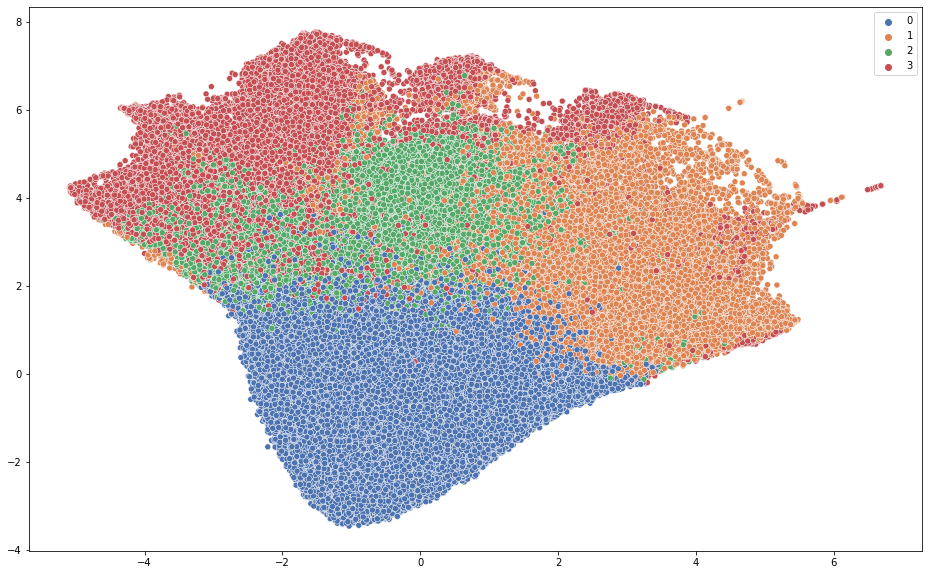

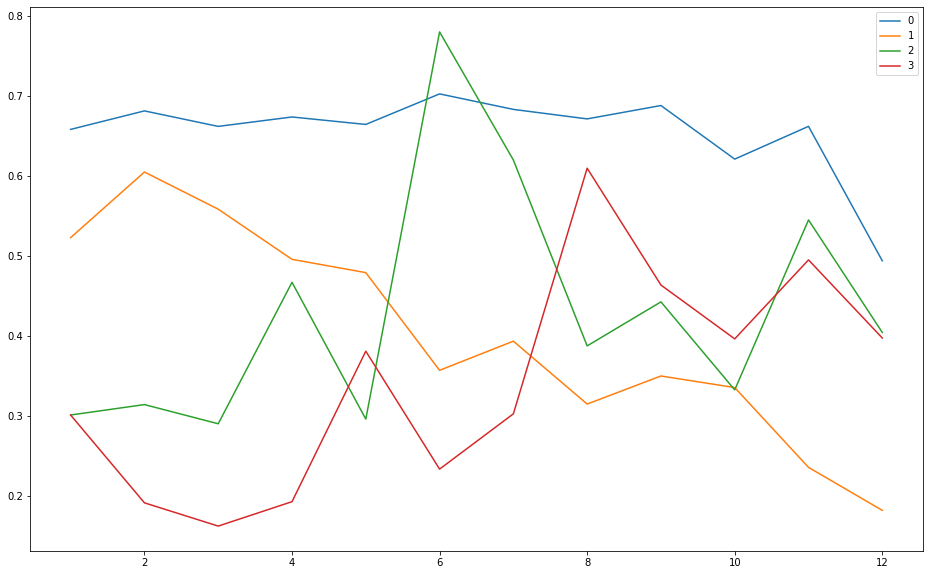

In [34]:
# последнее приемлемое значение - 4 кластера
# дальше идёт значительное ухудшение показателей
visual(months_df, 12, 4)

Интерпретация.

Скорее всего есть какие-то перекосы в определении месяца, так как у нас есть только неделя года и день недели. Но Первое января года может относиться к 53 неделе года, поэтому тут не очень точно получается определять.

Кластер 0 (синяя линия) - стабильное большое число покупок весь год, но снижение к концу года.

Кластер 1 (оранжевая линия) - много покупок в первые месяца года, то есть зимой.Возможно любители зимнего отдыха.

Кластер 2 (зеленая линия) - увеличение покупок летом, возможно отпускные траты.

Кластер 3 (красная линия) - количество покупок возрастает в августе. Похоже на родителей школьников.

**Составить профили клиентов по тратам**

In [25]:
# данные по суммам уже нормализованы, просто разобъем их по диапазонам
def my_func(x):
    return np.histogram(x, np.arange(0, 1.1, 0.1))

In [26]:
amnt_df = pd.DataFrame(full_df.groupby('app_id')['amnt'].apply(my_func).apply(lambda x: x[0]).tolist(), 
             columns=[str(round(x, 2)) for x in np.arange(0.1, 1.1, 0.1)])

In [27]:
# нормализуем данные
amnt_df = amnt_df.div(amnt_df.sum(axis=1), axis=0)
amnt_df.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,0.011050,0.000000,0.160221,0.397790,0.331492,0.082873,0.016575,0.0,0.0,0.0
1,0.000000,0.019663,0.356742,0.432584,0.162921,0.028090,0.000000,0.0,0.0,0.0
2,0.008734,0.109170,0.344978,0.397380,0.139738,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.074627,0.432836,0.238806,0.179104,0.074627,0.000000,0.0,0.0,0.0
4,0.025641,0.000000,0.051282,0.470085,0.162393,0.188034,0.102564,0.0,0.0,0.0


In [28]:
# рассчитаем метрики кластеризации по подвыборке из 10% данных
count_clusters(amnt_df.sample(frac=0.1, random_state=43))

,"Kmeans, n_classes",2,3,4,5,6,7,8,9,10
0,Коэффициент силуэта,0.404069,0.399306,0.331875,0.322113,0.306321,0.274383,0.267522,0.265289,0.269622
1,Индекс Калинского-Харабаза,6680.987814,6090.029369,6583.547531,6793.157927,6508.650686,6127.765555,5916.398384,5661.426889,5519.452284
2,Индекс Дэвиса-Болдина,1.131918,1.005193,1.011903,0.960907,1.032237,1.087283,1.086144,1.086181,1.068682


Распределение по кластерам: [73373 25148 12179]


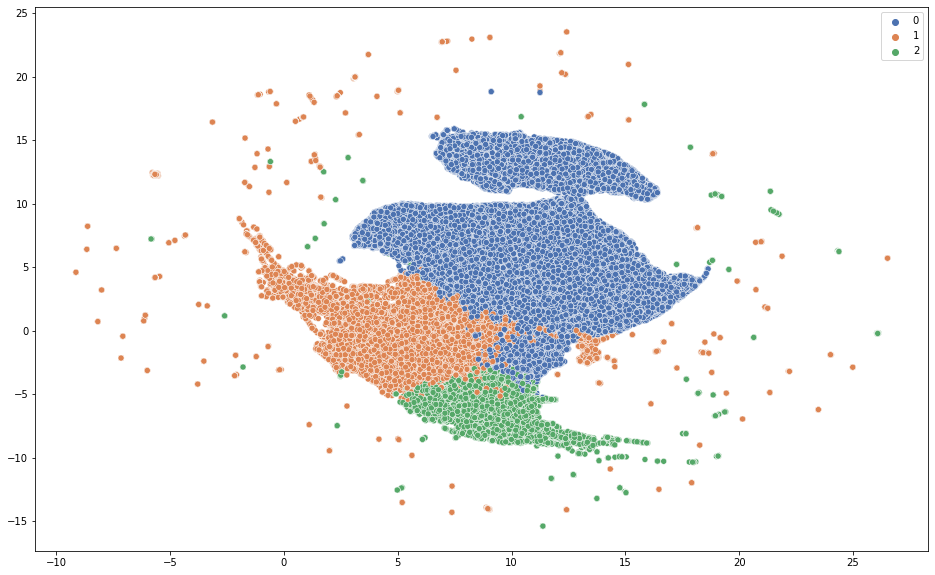

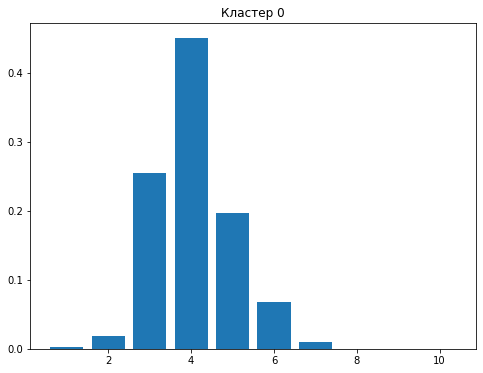

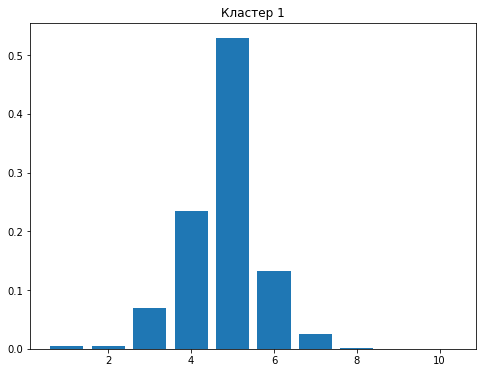

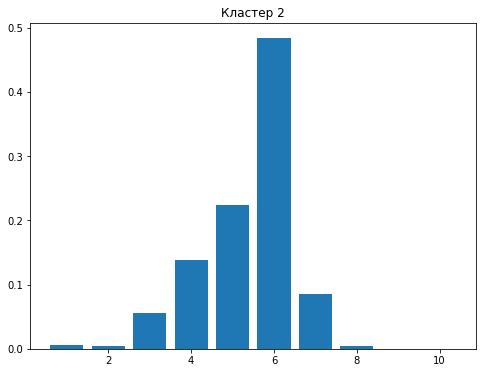

In [29]:
# минимальное значение индекса Дэвиса-Болдина и практически максимальное для коэффициента силуэта - 3 кластера
cl = KMeans(n_clusters=3, random_state=20)
clusters = cl.fit(amnt_df).predict(amnt_df)
print(f'Распределение по кластерам: {np.unique(clusters, return_counts=True)[1]}')

#Уменьшаем размерность
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(amnt_df)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=reducer.embedding_[:, 0], y=reducer.embedding_[:, 1],
    hue=clusters,
    palette="deep",
    legend="full",
)
_ = plt.legend()

for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.title(f'Кластер {i}')
    plt.bar(range(1, 11), cl.cluster_centers_[i])
    plt.show()    

Интерпретация.

Кластеры целом похожи друг на друга - мало дешевых покупок и мало дорогих. Основное отличие в перемещении пика - с увеличением номера кластера увеличивается стоимость наибольшего числа покупок.

**Составить профили интересов, опираясь на mcc-коды транзакций**

In [30]:
full_df['mcc_category'].nunique()

28

In [31]:
mcc_df = pd.pivot_table(full_df, values='transaction_number', index='app_id', columns='mcc_category',
               aggfunc='count', fill_value=0)

In [32]:
# нормализуем данные по категориям трат
mcc_df = mcc_df.div(mcc_df.max(axis=1), axis=0)
mcc_df.head()

mcc_category,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
app_id,,,,,,,,,,,,,,,,,,,,,
0,0.348624,1.000000,0.009174,0.009174,0.000000,0.000000,0.100917,0.036697,0.055046,0.000000,...,0.0,0.00,0.018349,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.836735,1.000000,0.214286,0.255102,0.224490,0.071429,0.204082,0.000000,0.040816,0.030612,...,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.758621,0.022989,0.011494,0.172414,0.045977,0.000000,0.034483,0.000000,0.000000,...,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.600000,0.850000,1.000000,0.300000,0.050000,0.050000,0.300000,0.000000,0.000000,0.000000,...,0.0,0.05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.058140,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,0.000000,0.000000,...,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# рассчитаем метрики кластеризации по подвыборке из 10% данных
count_clusters(mcc_df.sample(frac=0.1, random_state=43))

,"Kmeans, n_classes",2,3,4,5,6,7,8,9,10
0,Коэффициент силуэта,0.314146,0.319873,0.282591,0.294533,0.296964,0.247402,0.257612,0.259389,0.256382
1,Индекс Калинского-Харабаза,4748.880439,3686.710688,3168.491546,2966.814079,2688.875071,2426.998714,2232.197560,2091.274083,1969.818296
2,Индекс Дэвиса-Болдина,1.309667,1.685187,1.611333,1.446596,1.476832,1.579877,1.481677,1.470036,1.543339


Распределение по кластерам: [64685 46015]


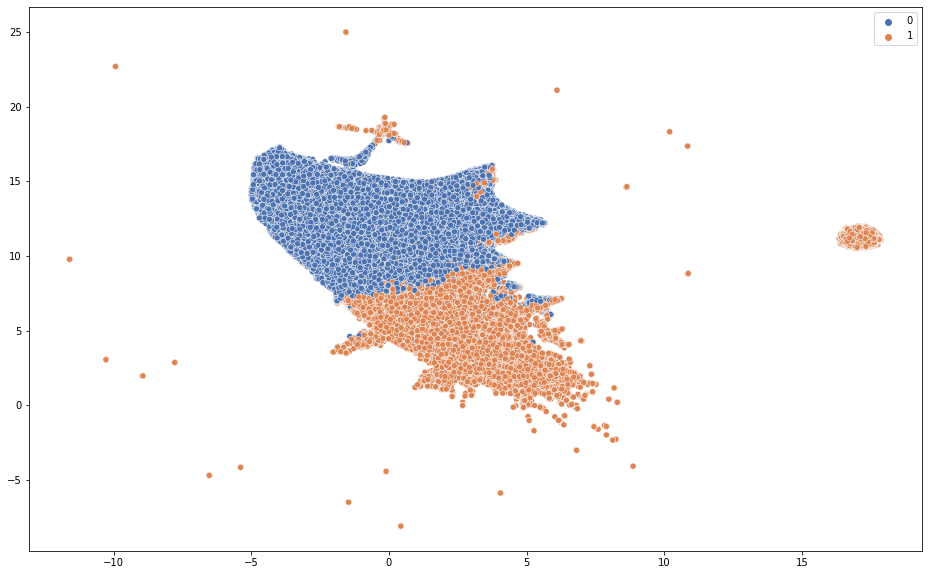

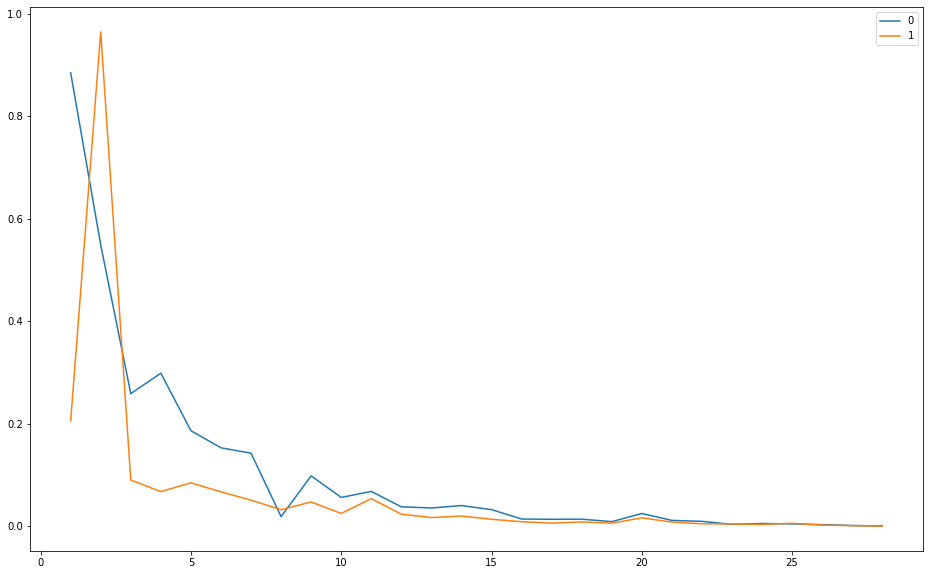

In [36]:
visual(mcc_df, 28, 2)

Интерпретация.

Тяжело оценить не зная значение кодов. 

Кластер 0 - большинство покупок с mcc=1.Есть немного с mcc=4 и 5. Остальных примерно одинаково мало.

Кластер 2 - большинство покупок с mcc=2. Остальных примерно одинаково мало.
